In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Load the dataset
data = pd.read_csv('gld_price_data.csv')
print(data.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [3]:
df = data[['Date', 'GLD']].copy()
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date        GLD
0 2008-01-02  84.860001
1 2008-01-03  85.570000
2 2008-01-04  85.129997
3 2008-01-07  84.769997
4 2008-01-08  86.779999


In [4]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df = fill_missing_values_date(df, 'Date', 'GLD')
df.head(10)

,Date,GLD
0,2008-01-02,84.860001
1,2008-01-03,85.570000
2,2008-01-04,85.129997
3,2008-01-05,85.009997
4,2008-01-06,84.889997
5,2008-01-07,84.769997
6,2008-01-08,86.779999
7,2008-01-09,86.550003
8,2008-01-10,88.250000
9,2008-01-11,88.580002


In [5]:
df.set_index('Date', inplace=True)

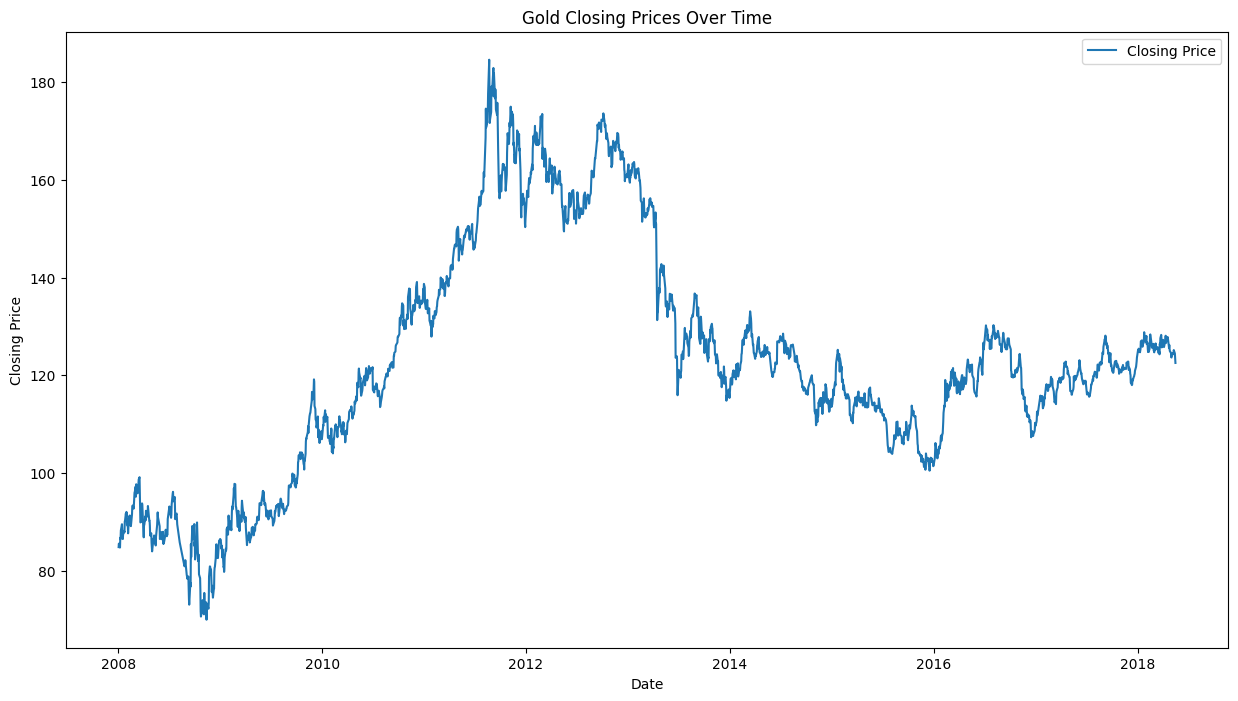

In [6]:
# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GLD'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Gold Closing Prices Over Time')
plt.legend()
plt.show()

In [7]:
# Create training and testing datasets
train_start_dt = '2008-01-01'
test_start_dt = '2018-05-01'
train = df.loc[train_start_dt:test_start_dt]
test = df.loc[test_start_dt:]
train.head()

,GLD
Date,
2008-01-02,84.860001
2008-01-03,85.570000
2008-01-04,85.129997
2008-01-05,85.009997
2008-01-06,84.889997


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2018-05-01 to 2018-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD     16 non-null     float64
dtypes: float64(1)
memory usage: 256.0 bytes


In [9]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [10]:
# Sử dụng auto_arima để tìm tham số p, d, q tốt nhất
auto_arima_model = pm.auto_arima(train['GLD'], 
                                 start_p=1, start_q=1,  # Khởi đầu cho p và q
                                 max_p=5, max_q=5,  # Giới hạn tối đa của p và q
                                 start_d=0, max_d=5,  # Tìm d trong khoảng từ 0 đến 2 (hoặc hơn nếu cần)
                                 seasonal=False,  # Dữ liệu không có tính chu kỳ
                                 trace=True,  # Hiển thị kết quả của mỗi lần thử nghiệm
                                 stepwise=True)  # Sử dụng phương pháp tìm kiếm tối ưu


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10765.372, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10799.130, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10771.948, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10774.985, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10797.521, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10764.397, Time=2.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10762.436, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10764.368, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10765.855, Time=2.46 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10760.728, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10770.276, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=10762.658, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10762.687, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10763.661, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0

In [11]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3773
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -5377.364
Date:                Sat, 19 Oct 2024   AIC                          10760.728
Time:                        00:07:48   BIC                          10779.434
Sample:                    01-02-2008   HQIC                         10767.379
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0830      0.009      8.911      0.000       0.065       0.101
ar.L2          0.0553      0.013      4.293      0.000       0.030       0.081
sigma2         1.0134      0.010    103.582      0.0

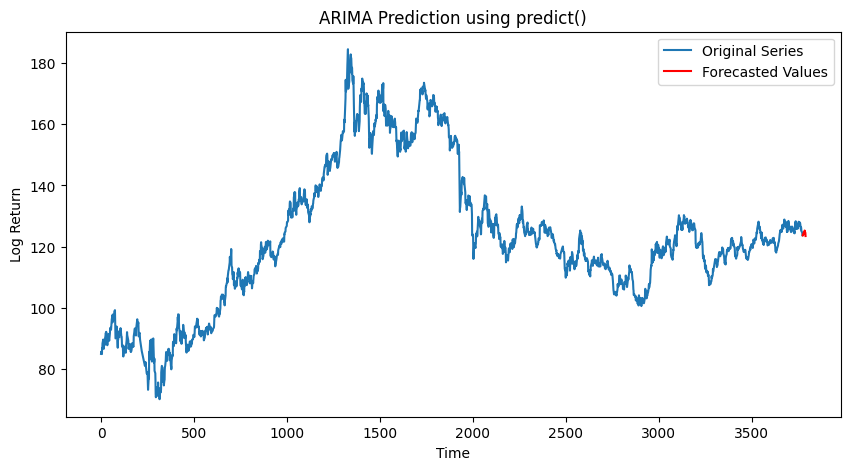

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = [x for x in train['GLD']]
predictions = list()

# walk-forward validation
for t in range(len(test['GLD'])):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['GLD'][t]
    history.append(obs)

# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train['GLD'])), train['GLD'], label="Original Series")
plt.plot(np.arange(len(train['GLD'])+1, len(train['GLD']) + len(test['GLD'])+1), predictions, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

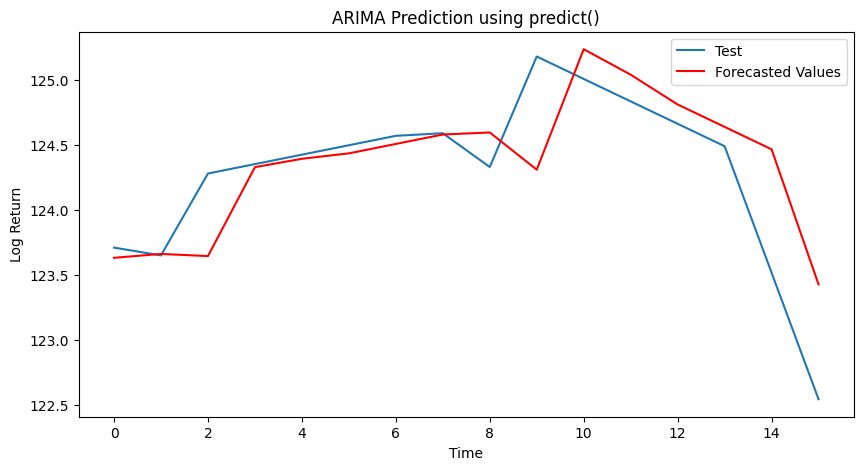

In [13]:
# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test['GLD'])), test['GLD'], label="Test")
plt.plot(np.arange(len(test['GLD'])), predictions, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [14]:
# Tính toán các chỉ số đánh giá mô hình
mse = mean_squared_error(test['GLD'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['GLD'], predictions)
mape = np.mean(np.abs((test['GLD'] - predictions) / test['GLD'])) * 100
r2 = r2_score(test['GLD'], predictions)

# In các chỉ số
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

MSE: 0.19164184521408595
RMSE: 0.4377691688710912
MAE: 0.28838257960784297
MAPE: 0.2325025749276433%
R²: 0.5217075043755472


# có chuẩn hóa

In [15]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
train_scaled = train.copy()
train_scaled['GLD'] = scaler.fit_transform(train[['GLD']])

# Transform the test data using the same scaler
test_scaled = test.copy()
test_scaled['GLD'] = scaler.transform(test[['GLD']])

In [16]:
train_scaled

,GLD
Date,
2008-01-02,0.129680
2008-01-03,0.135876
2008-01-04,0.132036
2008-01-05,0.130989
2008-01-06,0.129942
...,...
2018-04-27,0.478881
2018-04-28,0.478052
2018-04-29,0.477223


In [17]:
# Find the best parameters using auto_arima on the scaled training data
auto_arima_model = pm.auto_arima(train_scaled['GLD'], 
                                 start_p=1, start_q=1,
                                 max_p=5, max_q=5,
                                 start_d=0, max_d=5,
                                 seasonal=False,
                                 trace=True,
                                 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25002.578, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24969.693, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24996.875, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24993.769, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24971.303, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-25004.405, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-25006.388, Time=1.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-25004.455, Time=1.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-25002.478, Time=1.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-25008.096, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24998.548, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-25006.166, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-25006.113, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-25004.282, Time=0.31 sec
 ARIM

In [18]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3773
Model:               SARIMAX(2, 1, 0)   Log Likelihood               12507.048
Date:                Sat, 19 Oct 2024   AIC                         -25008.096
Time:                        00:08:02   BIC                         -24989.390
Sample:                    01-02-2008   HQIC                        -25001.445
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0831      0.009      8.921      0.000       0.065       0.101
ar.L2          0.0553      0.013      4.294      0.000       0.030       0.081
sigma2      7.718e-05   7.45e-07    103.582      0.0

In [19]:
# Walk-forward validation with the scaled data
history = [x for x in train_scaled['GLD']]
predictions = list()

for t in range(len(test_scaled['GLD'])):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_scaled['GLD'][t]
    history.append(obs)

In [20]:
predictions_inverse = scaler.inverse_transform([predictions])[0]

In [21]:
# Tính toán các chỉ số đánh giá mô hình
mse = mean_squared_error(test['GLD'], predictions_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['GLD'], predictions_inverse)
mape = np.mean(np.abs((test['GLD'] - predictions_inverse) / test['GLD'])) * 100
r2 = r2_score(test['GLD'], predictions_inverse)

# In các chỉ số
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

MSE: 0.19163467422713493
RMSE: 0.43776097841988487
MAE: 0.28837848050164716
MAPE: 0.23249920392218346%
R²: 0.5217254014545545


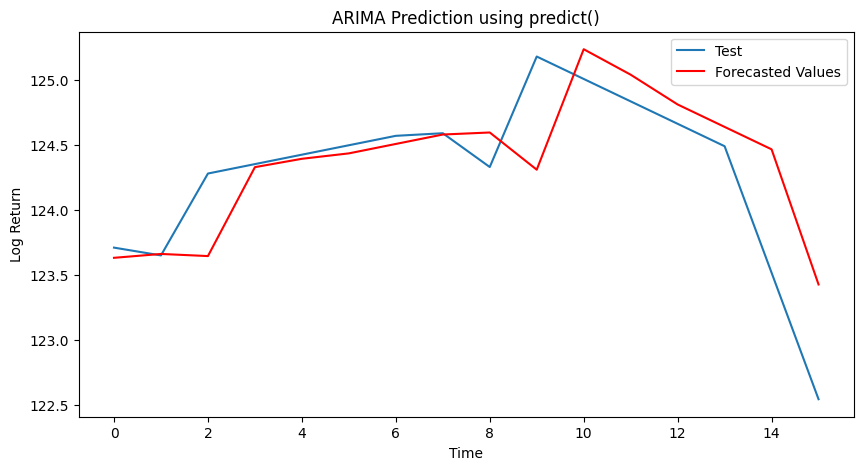

In [22]:
# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test['GLD'])), test['GLD'], label="Test")
plt.plot(np.arange(len(test['GLD'])), predictions_inverse, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

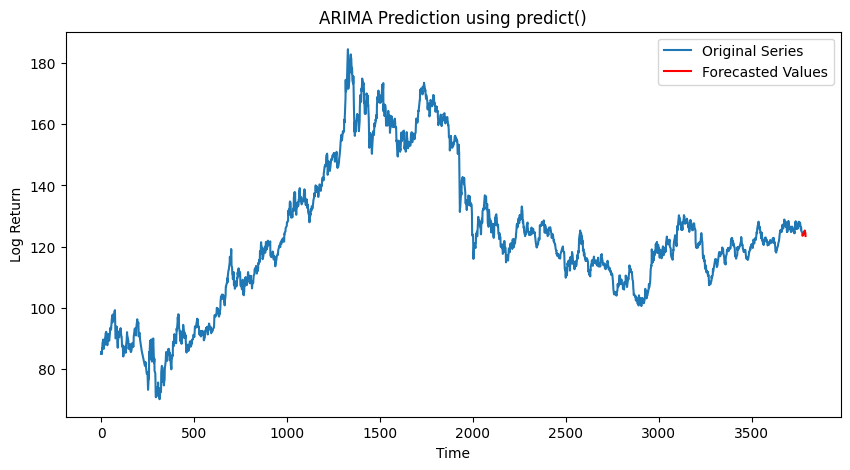

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train['GLD'])), train['GLD'], label="Original Series")
plt.plot(np.arange(len(train['GLD'])+1, len(train['GLD']) + len(test['GLD'])+1), predictions_inverse, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()